In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql.types import *
from pyspark.sql.functions import col, to_timestamp, unix_timestamp, substring, from_json
from decimal import Decimal

spark = SparkSession \
    .builder \
    .appName("StreamingPlot") \
    .getOrCreate()

tickData_schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('symbol', StringType(), True),
    StructField('side', StringType(), True),
    StructField('size', StringType(), True),
    StructField('price', StringType(), True),
    StructField('tickDirection', StringType(), True),
    StructField('trdMatchID', StringType(), True),
    StructField('grossValue', StringType(), True),
    StructField('homeNotional', StringType(), True),
    StructField('foreignNotional', StringType(), True)
])

In [2]:
# Load tick data produced by kafka_pyspark.py
df_raw = spark.readStream.option("header","false").schema(tickData_schema).csv("./output/tick_data/destination")
df_raw.createOrReplaceTempView("trade_history")

aggInterval = "1 minutes"

def createSQLStatement(interval):
    switcher = {
        "15 seconds" : ",cast(concat(date(timestamp),' ',hour(timestamp),':',minute(timestamp),':',floor(second(timestamp)/15)*15) as timestamp) as group_column",
        "30 seconds" : ",cast(concat(date(timestamp),' ',hour(timestamp),':',minute(timestamp),':',floor(second(timestamp)/30)*30) as timestamp) as group_column",
        "1 minutes"  : ",cast(concat(date(timestamp),' ',hour(timestamp),':',minute(timestamp)) as timestamp) as group_column",
        "5 minutes"  : ",cast(concat(date(timestamp),' ',hour(timestamp),':',floor(minute(timestamp)/5)*5) as timestamp) as group_column",
        "15 minutes" : ",cast(concat(date(timestamp),' ',hour(timestamp),':',floor(minute(timestamp)/15)*15) as timestamp) as group_column",
        "1 hours"  : ",cast(concat(date(timestamp),' ',hour(timestamp),':00') as timestamp) as group_column",
        "4 hours"  : ",cast(concat(date(timestamp),' ',floor(hour(timestamp)/4)*4,':00') as timestamp) as group_column",
        "6 hours"  : ",cast(concat(date(timestamp),' ',floor(hour(timestamp)/6)*6,':00') as timestamp) as group_column",
        "12 hours" : ",cast(concat(date(timestamp),' ',floor(hour(timestamp)/12)*12,':00') as timestamp) as group_column",
        "1 days"  : ",cast(concat(date(timestamp),' ','00:00') as timestamp) as group_column"
    }
    return switcher.get(interval, "Please input correct interval")

df_group_temp = spark.sql('SELECT timestamp, symbol, price, size '+ \
                             createSQLStatement(aggInterval)+ \
                             ' FROM trade_history')

df_group_temp.createOrReplaceTempView("hist_group")
df_interval = spark.sql('''SELECT group_column as timestamp,
                           symbol,
                           first(price) as open, 
                           max(price) as high, 
                           min(price) as low, 
                           last(price) as close,
                           sum(size) as volumn
                           FROM hist_group
                           group by symbol, group_column
                           ''')

# Write stream data to memory for visualization
query = df_interval.writeStream.queryName("interval_data").outputMode("complete").format("memory").start()

In [ ]:
'''
# Spark SQL/Dataframe code for manipulate output table

df_XBTU20 = spark.sql("Select timestamp, cast(timestamp as string) as ts_str, close as XBTU20 from interval_data where symbol = 'XBTU20'")
df_XBTM20 = spark.sql("Select cast(timestamp as string) as ts_str, close as XBTM20 from interval_data where symbol = 'XBTM20'")
df_agg = df_XBTU20.join(df_XBTM20, df_XBTU20.ts_str == df_XBTM20.ts_str, 'inner').orderBy('timestamp').drop(df_XBTU20.ts_str).drop(df_XBTM20.ts_str)
df_agg = df_agg.withColumn("Diff", df_agg.XBTU20 -df_agg.XBTM20)
df_agg.printSchema()
df_agg.show()
'''

In [5]:
import time
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline

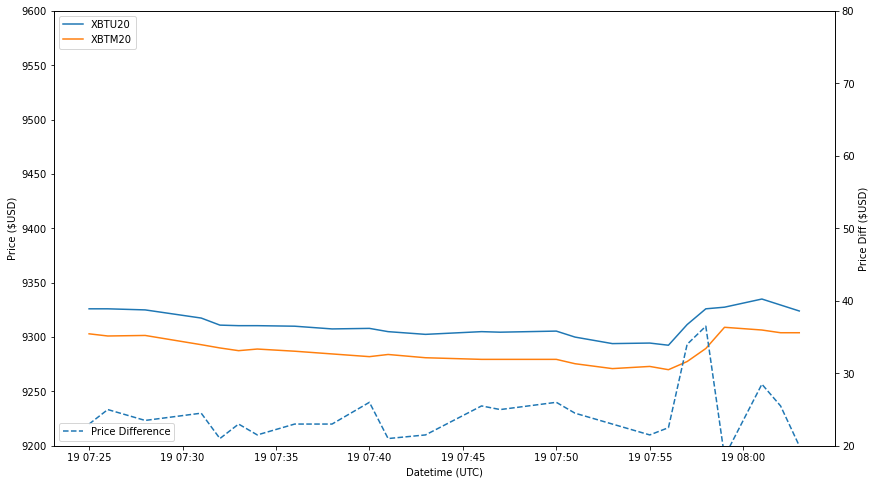

In [ ]:
count = 0

while count < 1000:
    display.clear_output(wait=True)
    
    pd_interval = spark.sql('select timestamp, symbol, close from interval_data').toPandas()
    xbtu20 = pd_interval[pd_interval['symbol']=='XBTU20'].set_index('timestamp').rename(columns={'close':'XBTU20'}).drop(columns=['symbol'])
    xbtm20 = pd_interval[pd_interval['symbol']=='XBTM20'].set_index('timestamp').rename(columns={'close':'XBTM20'}).drop(columns=['symbol'])
    pd_agg = pd.merge(left=xbtu20, right=xbtm20, left_on='timestamp', right_on='timestamp').sort_index().astype(float)
    pd_agg['Diff'] = pd_agg['XBTU20'] - pd_agg['XBTM20'] 
    
    fig, ax1 = plt.subplots(figsize=(14,8))

    ax1.set_xlabel('Datetime (UTC)')
    ax1.set_ylabel('Price ($USD)')

    ax1.plot(pd_agg['XBTU20'], label="XBTU20")
    ax1.plot(pd_agg['XBTM20'], label="XBTM20")
    ax1.set_ylim([9200, 9600])
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.set_ylabel('Price Diff ($USD)')
    ax2.plot(pd_agg['Diff'], label="Price Difference", linestyle='--')
    ax2.set_ylim([20, 80])
    ax2.legend(loc="lower left")
    plt.show()
    count = count +1
    time.sleep(60)
    
